# Team 3 Final Project Model
### Andy Stevens, Andrew Pan, Luke Vanni, Jameson Orvis

The purpose of this project was to develop a machine learning model to predict impurity spikes based on hourly readings of 40 different process variables for a given chemical process provided by DOW Chemical Company. We were not told the actual process this data is taken from. 

In [2]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
import datetime

## Load Data

,Date,x1:Primary Column Reflux Flow,x2:Primary Column Tails Flow,x3:Input to Primary Column Bed 3 Flow,x4:Input to Primary Column Bed 2 Flow,x5:Primary Column Feed Flow from Feed Column,x6:Primary Column Make Flow,x7:Primary Column Base Level,x8:Primary Column Reflux Drum Pressure,x9:Primary Column Condenser Reflux Drum Level,...,x32: Secondary Column Tray 2 Temperature,x33: Secondary Column Tray 1 Temperature,x34: Secondary Column Tails Temperature,x35: Secondary Column Tails Concentration,x36: Feed Column Recycle Flow,x37: Feed Column Tails Flow to Primary Column,x38: Feed Column Calculated DP,x39: Feed Column Steam Flow,x40: Feed Column Tails Flow,y:Impurity
0,1.448928e+09,327.813,45.7920,2095.06,2156.01,98.5005,95.4674,54.3476,41.0121,52.2353,...,84.7172,124.330,141.965,0.013060,62.8707,45.0085,66.6604,8.68813,99.9614,1.77833
1,1.448932e+09,322.970,46.1643,2101.00,2182.90,98.0014,94.9673,54.2247,41.0076,52.5378,...,83.4434,110.837,141.352,0.013666,62.8651,45.0085,66.5496,8.70683,99.8637,1.76964
2,1.448935e+09,319.674,45.9927,2102.96,2151.39,98.8229,96.0785,54.6130,41.0451,52.0159,...,84.1269,113.329,141.587,0.013498,62.8656,45.0085,66.0599,8.69269,100.2490,1.76095
3,1.448939e+09,327.223,46.0960,2101.37,2172.14,98.7733,96.1223,54.9153,41.0405,52.9477,...,108.7830,127.831,142.125,0.013104,62.8669,45.0085,67.9697,8.70482,100.3200,1.75226
4,1.448942e+09,331.177,45.8493,2114.06,2157.77,99.3231,94.7521,54.0925,40.9934,53.0507,...,88.9764,124.675,141.955,0.013085,62.8673,45.0085,67.6454,8.70077,100.6590,1.74357


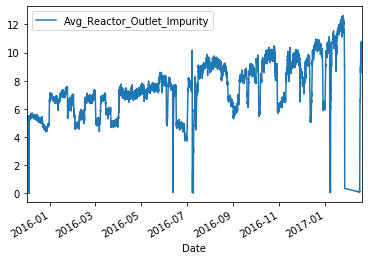

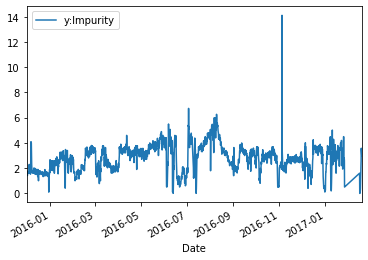

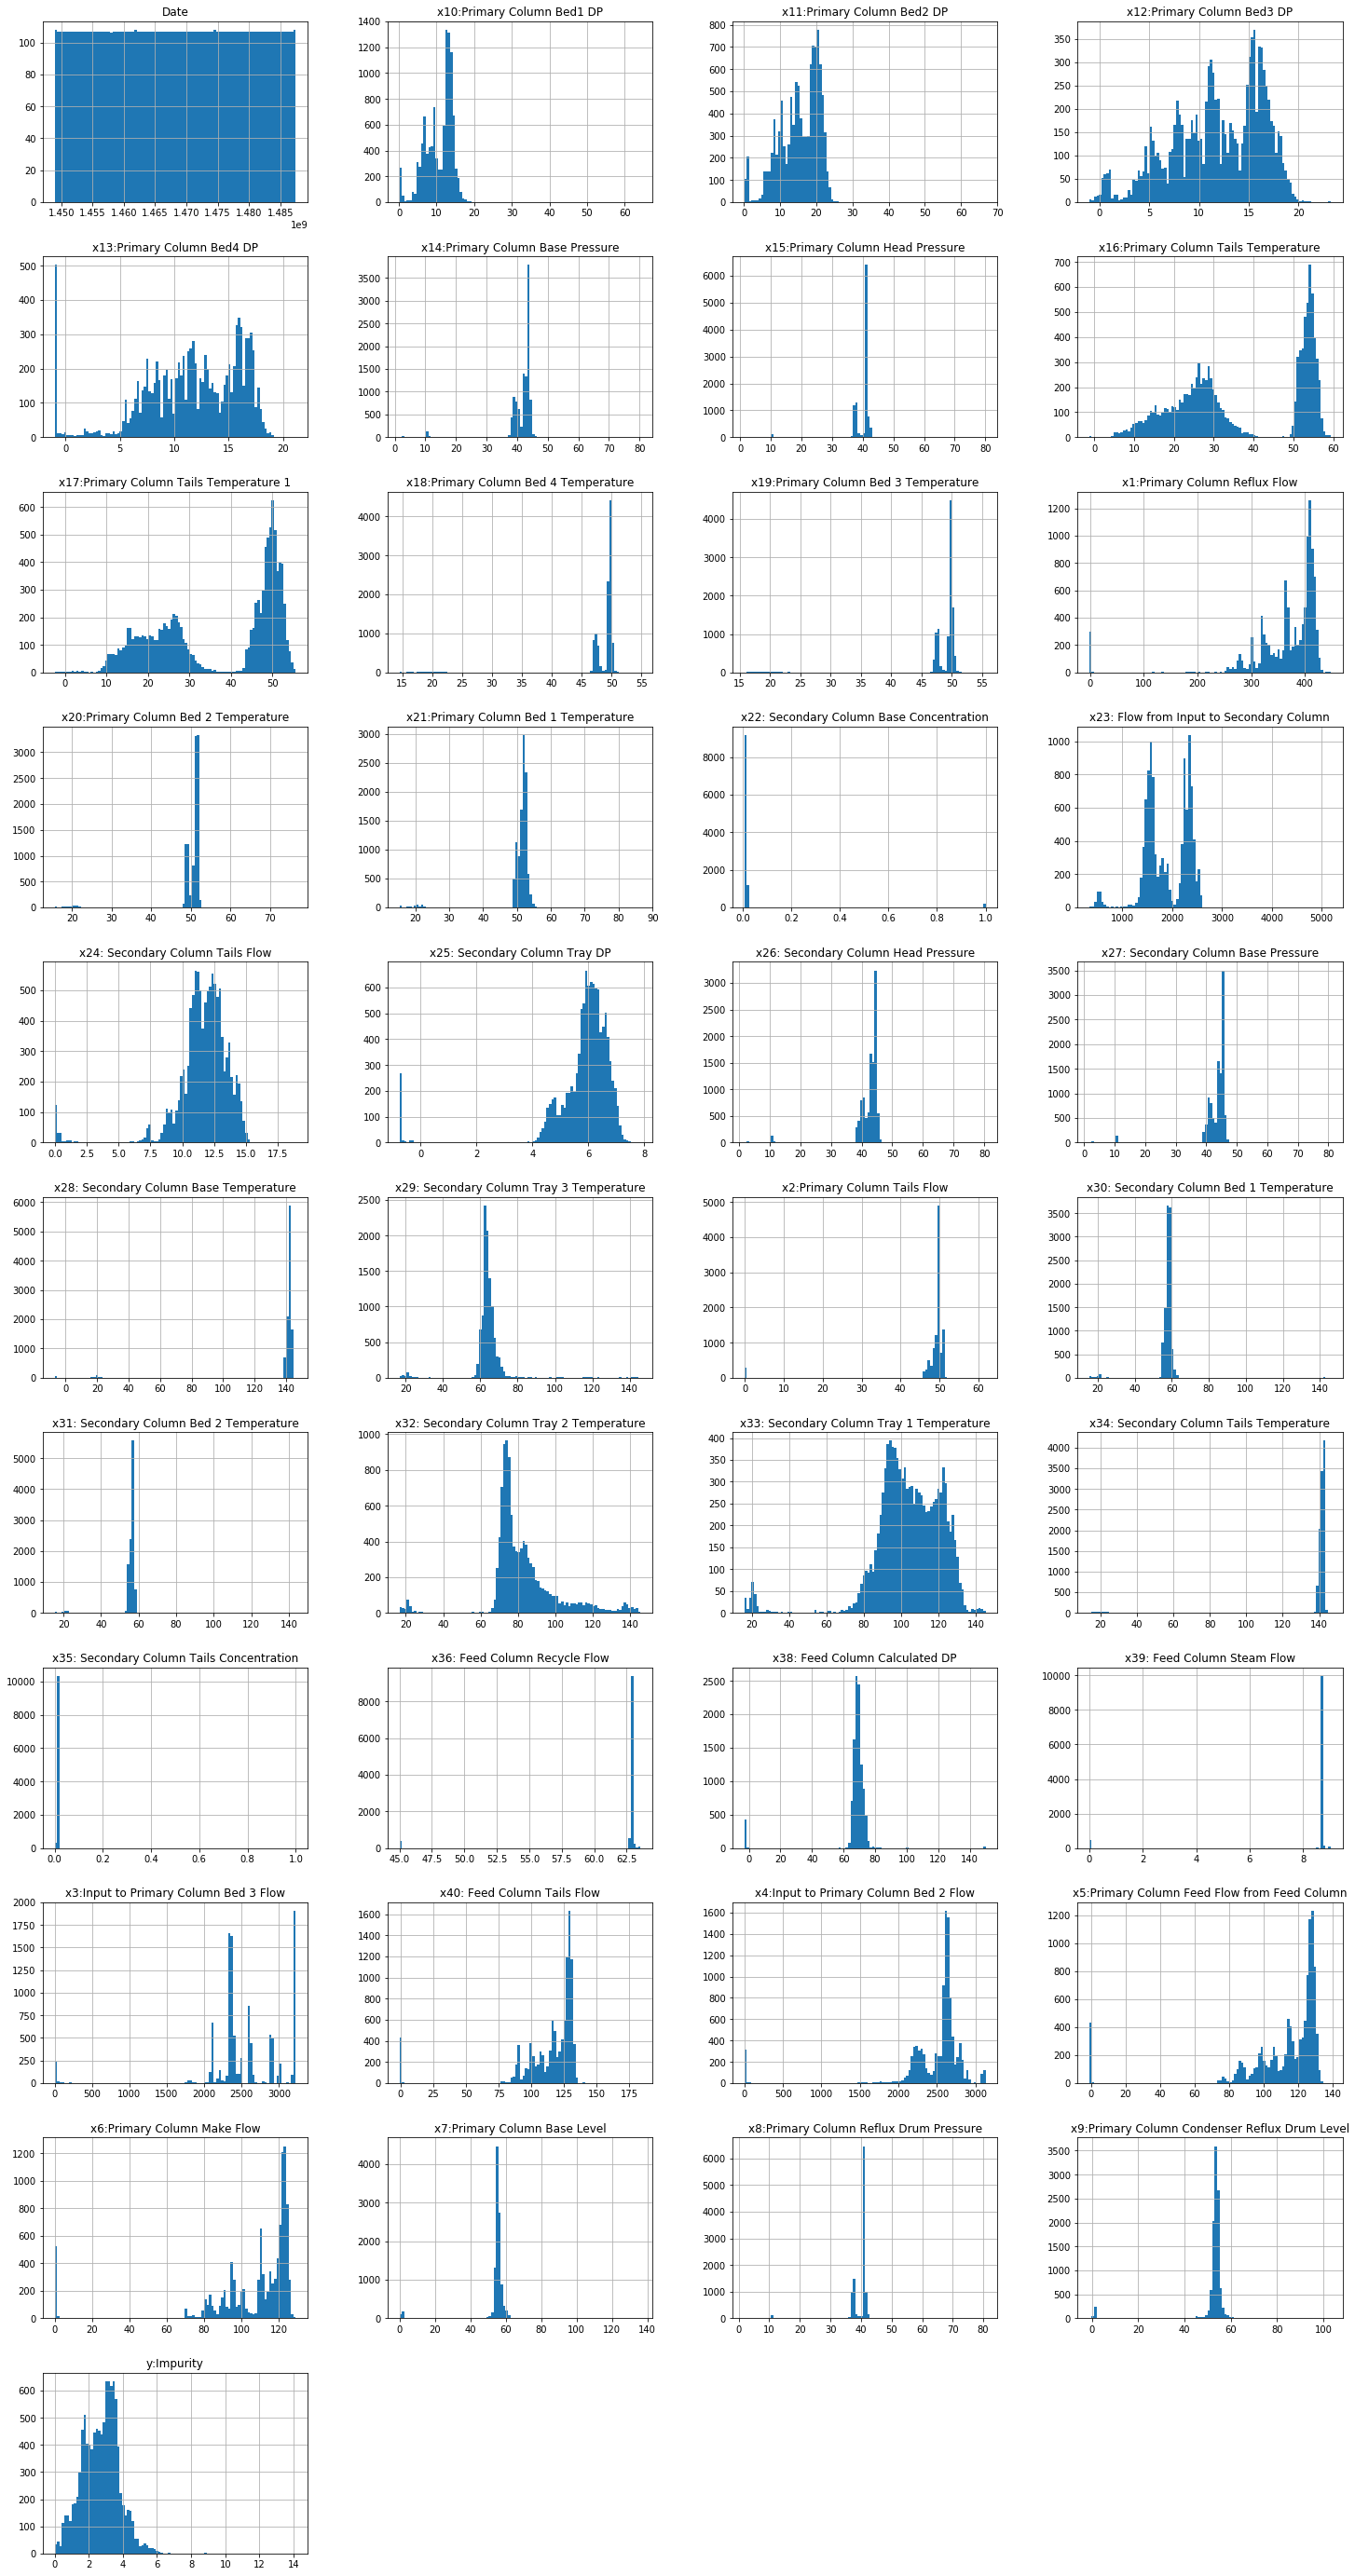

In [3]:
url_train = 'https://raw.githubusercontent.com/astevens37/COE3801Final/master/impurity_dataset-training.xlsx'
url_validate = 'https://raw.githubusercontent.com/astevens37/COE3801Final/master/impurity_dataset-validation.xlsx'
df_train = pd.read_excel(url_train)
df_validate = pd.read_excel(url_validate)

df_train.plot(x='Date', y='Avg_Reactor_Outlet_Impurity')
df_train.plot(x='Date', y='y:Impurity')

# Remove unneeded columns because they aren't features for us to build our model off of
df_train = df_train.drop(["Avg_Delta_Composition Primary Column","Primary Column Reflux/Feed Ratio","Primary Column Make/Reflux Ratio","Avg_Reactor_Outlet_Impurity"], axis=1)
df_validate = df_validate.drop(["Avg_Delta_Composition Primary Column","Primary Column Reflux/Feed Ratio","Primary Column Make/Reflux Ratio","Avg_Reactor_Outlet_Impurity"], axis=1)

#this code converts the date of each reading to UNIX time and adds it to our feature matrix, allowing us to use the date
#of the reading as a predictive feature.
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_validate['Date'] = pd.to_datetime(df_validate['Date'])

dates_train = df_train['Date'].tolist()
for i in range(len(dates_train)):
  dates_train[i] = pd.to_datetime(dates_train[i]).timestamp()
df_train['Date'] = dates_train

dates_validate = df_validate['Date'].tolist()
for i in range(len(dates_validate)):
  dates_validate[i] = pd.to_datetime(dates_validate[i]).timestamp()
df_validate['Date'] = dates_validate

#plots histograms of each feature to begin getting a feel for the data
df_train.hist(bins=100, figsize=(25,50), layout=(11,4))

df_train.head(5)

## Removing Rows Containing a Non-Numeric Value

In [4]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

In [5]:
df_train.isna().sum()

Date                                              0
x1:Primary Column Reflux Flow                    30
x2:Primary Column Tails Flow                     22
x3:Input to Primary Column Bed 3 Flow            21
x4:Input to Primary Column Bed 2 Flow            21
x5:Primary Column Feed Flow from Feed Column     21
x6:Primary Column Make Flow                      21
x7:Primary Column Base Level                     21
x8:Primary Column Reflux Drum Pressure           21
x9:Primary Column Condenser Reflux Drum Level    19
x10:Primary Column Bed1 DP                       19
x11:Primary Column Bed2 DP                       19
x12:Primary Column Bed3 DP                       19
x13:Primary Column Bed4 DP                       20
x14:Primary Column Base Pressure                 19
x15:Primary Column Head Pressure                 21
x16:Primary Column Tails Temperature             19
x17:Primary Column Tails Temperature 1           19
x18:Primary Column Bed 4 Temperature             19
x19:Primary 

In [6]:
numeric_map_train = df_train[df_train.columns[:]].applymap(is_real_and_finite)
real_rows_train = numeric_map_train.all(axis=1).copy().values #True if all values in a row are real numbers
X_train = np.array(df_train.loc[real_rows_train,:], dtype='float')
print(np.shape(df_train))
print(np.shape(X_train))
print('Number of rows removed from training: {}'.format(np.shape(df_train)[0]-np.shape(X_train)[0]))

numeric_map_val = df_validate[df_validate.columns[:]].applymap(is_real_and_finite)
real_rows_val = numeric_map_val.all(axis=1).copy().values #True if all values in a row are real numbers
X_validate = np.array(df_validate.loc[real_rows_val,:], dtype='float')
print(np.shape(df_validate))
print(np.shape(X_validate))
print('Number of rows removed from validation: {}'.format(np.shape(df_validate)[0]-np.shape(X_validate)[0]))

(10703, 42)
(10666, 42)
Number of rows removed from training: 37
(5959, 42)
(5735, 42)
Number of rows removed from validation: 224


## Standardizing The Data

In [7]:
from sklearn.model_selection import train_test_split

X = np.concatenate((X_train, X_validate), axis=0)

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42, shuffle=False)

scaler_train = preprocessing.StandardScaler().fit(X_train)

X_train = scaler_train.transform(X_train)
X_validate = scaler_train.transform(X_validate)

#importantly, we standardize our validation data set with respect to our testing data instead of itself in order to avoid 
#biasing the model.

# Labeling Failure Points

In [8]:
failure=[]
impurity_train = X_train[:,41]
impurity_val = X_validate[:,41]


In [9]:
#arbitrarily chosen impurity level for the failure threshold. We decided to treat this problem as a classification problem
#by considering impurity levels above a certain threshold to be failures, and we train our model to recognize these failures.
#Since we don't know what the actual process is, this number is entirely arbitrary, so we choose the mean plus half 
#the standard deviation of all impurity values. We explore different choices of a failure threshold later.

acceptable_max = np.mean(impurity_train) + (np.std(impurity_train)/2)

#assigning failure points in training
for i in range(len(X_train)):
  if impurity_train[i] >= acceptable_max:
    tf=1
  else:
    tf=0
  failure.append(tf)

#assigning failure points in validation set. Note that we decide the failure threshold based ONLY on the training set.
#Using the mean and standard deviation of both data sets together would bias the model. 
failure_val=[]
for i in range(len(X_validate)):
  if impurity_val[i] >= acceptable_max:
    tf=1
  else:
    tf=0
  failure_val.append(tf)

In [10]:
#Want to remove impurity level from feature matrix, so we don't effectively use the impurity level to predict itself.

X_train = X_train[:,:41]
X_validate = X_validate[:,:41]

## Covariance Matrix

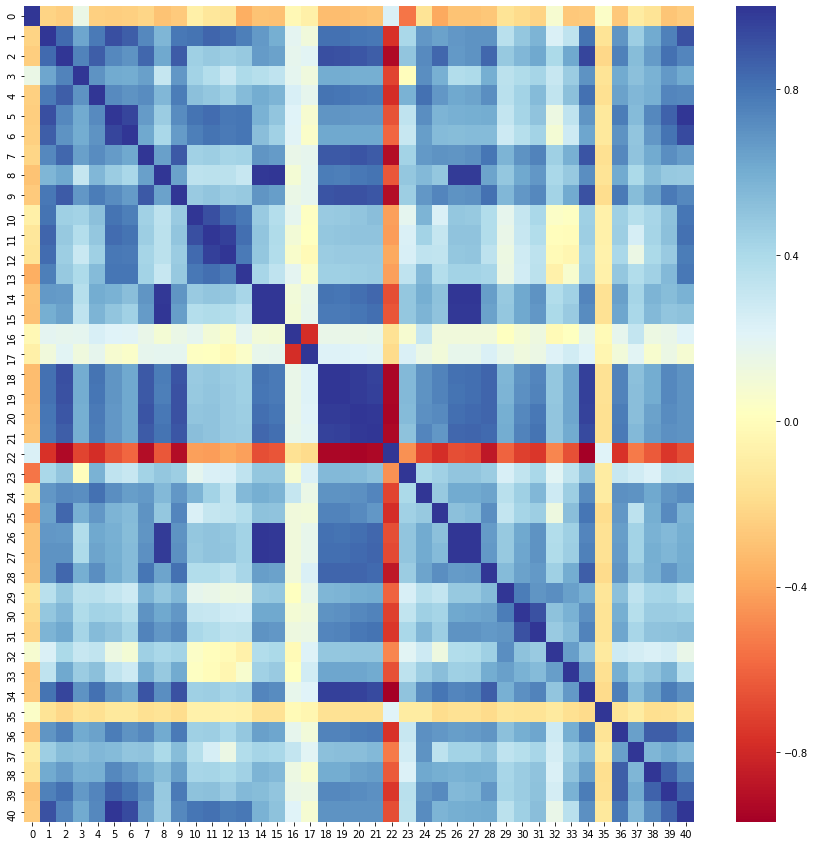

In [11]:
#we plot a covariance matrix for visualization purposes.

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.DataFrame(X_train).cov(), ax=ax, cmap='RdYlBu')

# Classification

In [16]:
#What follows are various attempts to use a variety of classifiers to predict which conditions correspond to an unacceptable
#impurity level in our validation data set by training the model on our test set. No clustering or otherwise clever
#techniques are used here to improve guesses. Some light hyperparameter tuning has been performed.

#Logistic Regression

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions_lr = model.predict(X_validate)
testing_class_report = classification_report(failure_val, predictions_lr, output_dict = True)
print(testing_class_report)

Testing Score: 0.8522934109938114
Validation Score: 0.8003487358326068
{'0': {'precision': 0.8367758186397984, 'recall': 0.669218372280419, 'f1-score': 0.7436758450861877, 'support': 2482}, '1': {'precision': 0.7810666666666667, 'recall': 0.9003996311097449, 'f1-score': 0.8364986434385264, 'support': 3253}, 'accuracy': 0.8003487358326068, 'macro avg': {'precision': 0.8089212426532326, 'recall': 0.7848090016950819, 'f1-score': 0.790087244262357, 'support': 5735}, 'weighted avg': {'precision': 0.8051765385406534, 'recall': 0.8003487358326068, 'f1-score': 0.7963266843259711, 'support': 5735}}


In [0]:
#Support vector machine

from sklearn import svm

model = svm.SVC(gamma='auto', C=10)
model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions_svm = model.predict(X_validate)
print(predictions_svm.size)

testing_class_report = classification_report(failure_val, predictions_svm, output_dict = True)
print(testing_class_report)

Testing Score: 0.9019839825263924
Validation Score: 0.55640802092415
5735
{'0': {'precision': 0.4927772600186393, 'recall': 0.8521353746978243, 'f1-score': 0.6244464127546501, 'support': 2482}, '1': {'precision': 0.7456687456687456, 'recall': 0.3307715954503535, 'f1-score': 0.4582623509369677, 'support': 3253}, 'accuracy': 0.55640802092415, 'macro avg': {'precision': 0.6192230028436925, 'recall': 0.5914534850740889, 'f1-score': 0.5413543818458089, 'support': 5735}, 'weighted avg': {'precision': 0.6362220730648112, 'recall': 0.55640802092415, 'f1-score': 0.5301836833574538, 'support': 5735}}


In [0]:

#Random forest classifier without hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions = model.predict(X_validate)
print(predictions.size)

testing_class_report = classification_report(failure_val, predictions, output_dict = True)
print(testing_class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Testing Score: 0.9954495813614852
Validation Score: 0.708456843940715
5735
{'0': {'precision': 0.6254646840148699, 'recall': 0.8134568896051572, 'f1-score': 0.7071803852889667, 'support': 2482}, '1': {'precision': 0.8153171120861588, 'recall': 0.6283430679372887, 'f1-score': 0.7097222222222221, 'support': 3253}, 'accuracy': 0.708456843940715, 'macro avg': {'precision': 0.7203908980505143, 'recall': 0.7208999787712229, 'f1-score': 0.7084513037555944, 'support': 5735}, 'weighted avg': {'precision': 0.733152556467512, 'recall': 0.708456843940715, 'f1-score': 0.7086221630647086, 'support': 5735}}


In [0]:
#Hyperparameter tuning for random forest. 
#Adapted from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

#Leaving this line commented by default. This literally took me an hour to run. 
#The hyperparameters from this are used in the code block below.

#rf_random.fit(X_train, failure)

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=1,max_features='auto',max_depth=50,bootstrap=False)
model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions = model.predict(X_validate)
print(predictions.size)

testing_class_report = classification_report(failure_val, predictions, output_dict = True)
print(testing_class_report)

#Better, but still overfitted and outclassed by just logistic regression. 

Testing Score: 1.0
Validation Score: 0.7748910200523104
5735


NameError: name 'classification_report' is not defined

# Cluster Classification


This is where things get interesting. Using a simple Logistic Regression classifier, we can achieve a validation accuracy of about 80%, but we would like to do even better. We know that chemical processes can have multiple steady states, or normal operating conditions. There may be multiple steady state operating conditions in our data. In each of these steady state operating conditions, variables might have different ideal values. Therefore our classifier in each cluster may be different. To capture this behavior, we seek to cluster our data into different operating conditions, and then train an individual classifier for each cluster. For our validation data, our data pipeline would then become predict the cluster every data point belongs to, and then use that particular cluster's corresponding model to predict whether that point is an impurity peak or not.

[0 0 0 ... 0 0 0]
[2 2 2 ... 0 0 0]
[0 0 0 ... 1 1 1]
[3 3 3 ... 4 4 4]
[2 2 2 ... 0 0 0]
[0 0 0 ... 2 2 2]
[6 6 6 ... 3 3 3]
[0 0 0 ... 7 7 7]
[2 2 2 ... 0 0 0]


Text(0, 0.5, 'mean silhouette score')

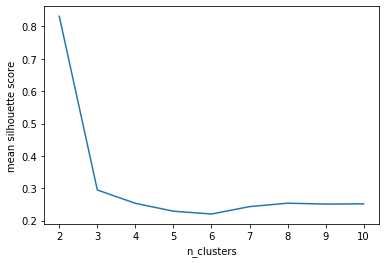

In [13]:
#plotting the mean silhouette score of all points as a function of number of clusters to find the ideal number of KMeans
#clusters for this data.

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

scores = []
for i in range(2,11):
    n_clusters = i
    model = KMeans(n_clusters=n_clusters)
    model.fit(X_train)
    y_predict = model.predict(X_train)
    print(y_predict)
    scores.append(silhouette_score(X_train, y_predict))

fig, ax = plt.subplots()
ax.plot(range(2,11), scores)
ax.set_xlabel('n_clusters')
ax.set_ylabel('mean silhouette score')

Text(0.5, 1.0, 'Actual training set')

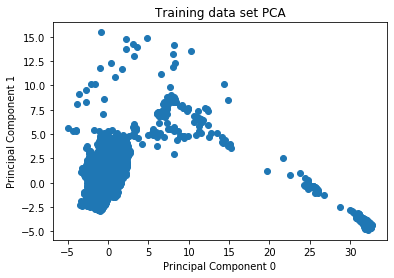

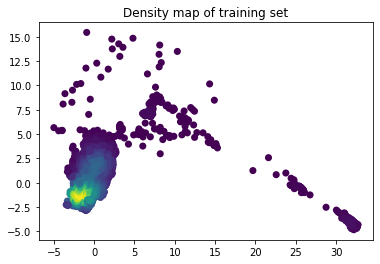

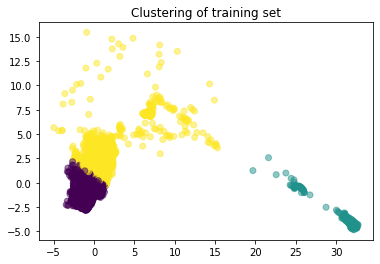

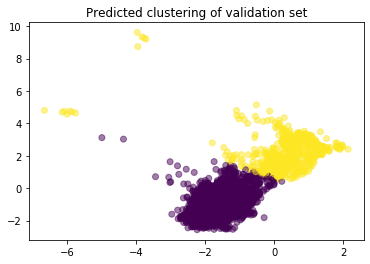

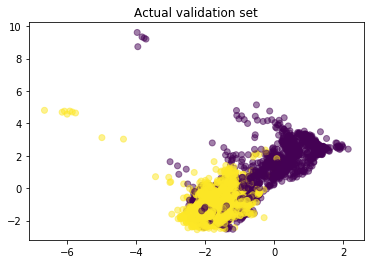

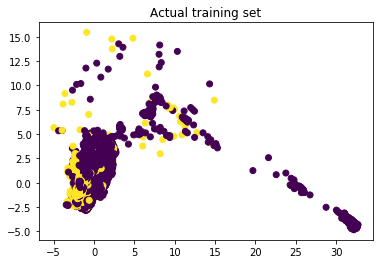

In [14]:
#this code block uses PCA to visualize our data + clustering.

pca = PCA(n_components = 2)

from scipy.stats import gaussian_kde
n_comp = 3 #we will use 3 clusters. 

X_train_pca = pca.fit_transform(X_train)
xy = np.vstack([X_train_pca[:,0],X_train_pca[:,1]])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1])
ax.set_title('Training data set PCA')
ax.set_xlabel('Principal Component 0')
ax.set_ylabel('Principal Component 1')

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=z, s=50, edgecolor='')
ax.set_title('Density map of training set')

fig, ax = plt.subplots()
model = KMeans(n_clusters=n_comp)
model.fit(X_train_pca)
y_predict = model.predict(X_train_pca)
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_predict, cmap='viridis', alpha=0.5)
ax.set_title('Clustering of training set')

fig, ax = plt.subplots()
X_validate_pca = pca.transform(X_validate)
y_predict = model.predict(X_validate_pca)
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=y_predict, cmap='viridis', alpha=0.5)
ax.set_title('Predicted clustering of validation set')

fig, ax = plt.subplots()
y_predict = model.predict(X_validate_pca)
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=failure_val, cmap='viridis', alpha=0.5)
ax.set_title('Actual validation set')

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=failure)
ax.set_title('Actual training set')

Several interesting things jump out from this visualization. First, most of the reading are contained in that large blob on the bottom left. As seen in the density map, within this large blob, there is a higher concentration of points in the bottom left corner. We make the assumption that the lower portion of this blob and the upper portion of this blob represent unique operating states of the chemical process. We seek a clustering algorithm that consider the upper and lower portions of the blob to be distinct. In our training data set clustering graph, we can see that our KMeans algorithm with 3 clusters does indeed divide up the lower left blob into upper and lower halves. The last two graphs show what we consider a failure point in yellow, and other points in dark purple. In the next code block, we divide our data into clusters and train a unique model based on each individual cluster. 

10988
Testing Score: 0.9933373712901272
1
Testing Score: 1.0
Testing Score: 0.8303821062441752


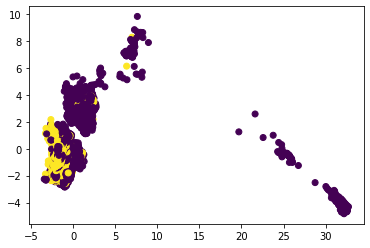

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

failure = np.array(failure)
cluster_model = KMeans(n_clusters=n_comp)
cluster_model.fit(X_train)
y_predict = cluster_model.predict(X_train)
scores = silhouette_samples(X_train, y_predict)

print(len(scores))

#we remove outliers based on the silhouette score of each point relative to its cluster. 
outlier_cutoff = 0.1
mask = (np.array(scores) > outlier_cutoff)
X_train_reduced = X_train[mask,:]
failure_reduced = failure[mask]

#plot the data with outliers removed
fig, ax = plt.subplots()
ax.scatter(X_train_pca[mask,0], X_train_pca[mask,1], c=failure[mask])

y_predict = cluster_model.predict(X_train_reduced)
#y_predict gives the cluster identification for each data point in our training set


models = []

#iterates through each cluster
for i in range(n_comp):
    
    mask = (y_predict == i)
    data = X_train_reduced[mask,:]
    masked_failure = failure_reduced[mask]

    if np.all(masked_failure == 0): 
        
        #you may be wondering why we define an entirely new class here. Well as it turns out, if you attempt
        #to train a logistic regression classifier on a data set where every point has the same classification,
        #the model will throw an error. This is a kind of dumb workaround where we make a dumb model that predicts
        #everything is a zero (i.e. not a failure).
        
        class dumb_model:           
            def _init_():
                print('yeet')
            
            def fit(X_train, y):
                print('lol')
                
            def predict(self, X):
                return np.zeros(data.shape[0])
            
            def score(self, X, y):
                return 1.0
        
        print(i)
        model = dumb_model()
    else:
        model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
        model.fit(data, masked_failure)
    print('Testing Score: {}'.format(model.score(data, masked_failure)))
    models.append(model)

{'0': {'precision': 0.8379006038086391, 'recall': 0.7268331990330379, 'f1-score': 0.7784250269687162, 'support': 2482}, '1': {'precision': 0.8107202680067002, 'recall': 0.8927144174608054, 'f1-score': 0.849743964886613, 'support': 3253}, 'accuracy': 0.8209241499564081, 'macro avg': {'precision': 0.8243104359076696, 'recall': 0.8097738082469217, 'f1-score': 0.8140844959276645, 'support': 5735}, 'weighted avg': {'precision': 0.8224834054888994, 'recall': 0.8209241499564081, 'f1-score': 0.8188784716150839, 'support': 5735}}


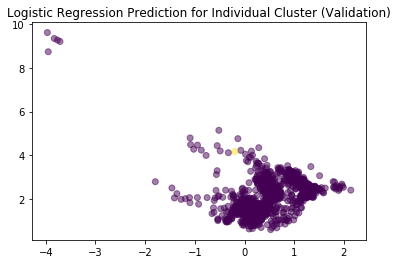

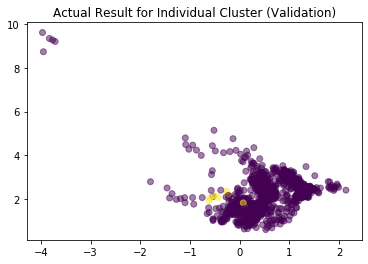

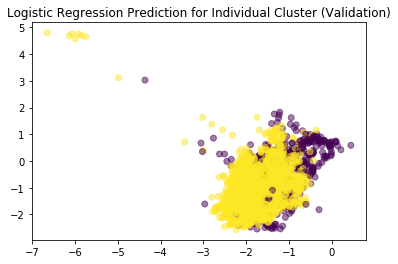

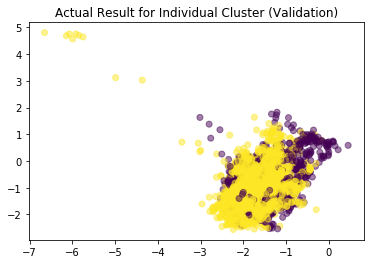

In [23]:
#We plot the results for the classifier in each individual cluster. Note that cluster 3 in our algorithm has everything considered not a failure,
#so we skip that to avoid errors. We also print the final classifier report at the end for our model.

predicted_clusters = cluster_model.predict(X_validate)

y_predict = np.zeros(X_validate.shape[0])
failure_val = np.array(failure_val)
for i in range(n_comp):
    mask = (predicted_clusters == i)
    data = X_validate[mask,:]
    if (data.shape[0] == 0):
        continue
    cluster_pred = models[i].predict(data)
    fig, ax = plt.subplots()
    ax.scatter(X_validate_pca[mask,0], X_validate_pca[mask,1], c=cluster_pred, cmap='viridis', alpha=0.5)
    ax.set_title('Logistic Regression Prediction for Individual Cluster (Validation)')
    
    fig, ax = plt.subplots()
    ax.scatter(X_validate_pca[mask,0], X_validate_pca[mask,1], c=failure_val[mask], cmap='viridis', alpha=0.5)
    ax.set_title('Actual Result for Individual Cluster (Validation)')
    y_predict[mask] = cluster_pred

testing_class_report = classification_report(failure_val, y_predict, output_dict = True) #clustering based model
print(testing_class_report)

We achieve an accuracy of 82.1% with our clustering + classification algorithm! A slight improvement from 80%. 

# Interesting Plots

In [ ]:
#Some more plots.

n_comps = 2
pca = PCA(n_components = n_comps)
X_train_pca = pca.fit_transform(X_train)
X_validate_pca = pca.transform(X_validate)
print(pca.explained_variance_ratio_)

kpca = KernelPCA(n_components = n_comps, kernel='rbf', gamma=0.1)
X_train_kPCA = kpca.fit_transform(X_train)
X_validate_kPCA = kpca.transform(X_validate)

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=failure)
ax.set_title('Training data set PCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=failure_val)
ax.set_title('Validation data set PCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=y_predict)
ax.set_title('Validation data set PCA predicted by classifier')

fig, ax = plt.subplots()
ax.scatter(X_train_kPCA[:,0], X_train_kPCA[:,1], c=failure)
ax.set_title('Training data set kPCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_kPCA[:,0], X_validate_kPCA[:,1], c=failure_val)
ax.set_title('Validation data set kPCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_kPCA[:,0], X_validate_kPCA[:,1], c=y_predict)
ax.set_title('Validation data set kPCA predicted by classifier')



[0.57012671 0.10144777]
